In [14]:
ls ../india

IND_adm2.CPG  IND_adm2.sbx      IND_adm3.CPG  IND_adm3.sbx
IND_adm2.dbf  IND_adm2.shp      IND_adm3.dbf  IND_adm3.shp
IND_adm2.prj  IND_adm2.shp.xml  IND_adm3.prj  IND_adm3.shp.xml
IND_adm2.sbn  IND_adm2.shx      IND_adm3.sbn  IND_adm3.shx


In [9]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.affinity import scale
from shapely.geometry import Point, Polygon
import plotly.express as px
import matplotlib.pyplot as plt
from pandas import DataFrame as DF
from scipy.stats import skew
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import seaborn as sns


sns.set(rc={'figure.figsize':(11.7,8.27)})


metadata_df = pd.read_csv("/media/Data/sis_dataset/full_sample_metadata.csv")


fig = px.scatter_geo(metadata_df, lat='Latitude',lon='Longitude', hover_name="id")
fig.update_layout(title = 'World map', title_x=0.5)
fig.show()

<AxesSubplot:>

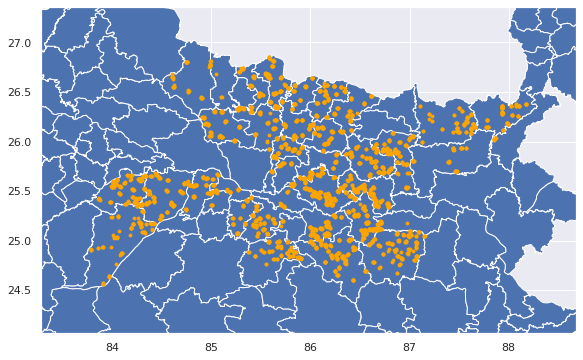

In [15]:
sample_points = [Point(xy) for xy in zip(metadata_df['Longitude'], metadata_df['Latitude'])]
sample_points_gdf = gpd.GeoDataFrame(metadata_df, geometry=sample_points)   


india = gpd.read_file("../india/IND_adm3.shp")

ax = india.plot(figsize=(10, 6))


minx, miny, maxx, maxy = gpd.GeoSeries(sample_points).total_bounds
margin = 0.5
ax.set_xlim(minx - margin, maxx + margin)
ax.set_ylim(miny - margin, maxy + margin)


sample_points_gdf.plot(ax=ax, marker='o', color='orange', markersize=8)

In [39]:
sample_points_gdf

Unnamed: 0    id  original_id  Year                 Name      Village  \
0              0     0            1  2018         Ashutosh Raj      Banauli   
1              1     1            2  2018           Dinesh Rai      Banauli   
2              2     2            3  2018            Kamla Rai      Banauli   
3              3     3            4  2018           Nandji Rai      Banauli   
4              4     4            5  2018          Nathuni Rai      Banauli   
...          ...   ...          ...   ...                  ...          ...   
3178        3178  3178          596  2020        Shambhu Yadav      paridah   
3179        3179  3179          597  2020          Md.Ashfaque       Tajpur   
3180        3180  3180          598  2020        Satish Parsad    Bibhutpur   
3181        3181  3181          599  2020  Surash Parsad Singh       Tajpur   
3182        3182  3182          600  2020       Sandeep Thakur  Sarairanjan   

                Block    District   Latitude  Longitude  \
0              Aiagon     Bhojpur  25.350228  84.614361   
1              Aiagon     Bhojpur  25.355369  84.624086   
2              Aiagon     Bhojpur  25.349651  84.617281   
3              Aiagon     Bhojpur  25.352689  84.616909   
4              Aiagon     Bhojpur  25.355438  84.622382   
...               ...         ...        ...        ...   
3178         Hasanpur  Samastipur  25.735030  86.225714   
3179  Sahpur baghauni  Samastipur  25.881508  85.672856   
3180       Bibhutipur  Samastipur  25.690239  85.995989   
3181        Chaktulsi  Samastipur  25.842229  85.622486   
3182       Bhagwatpur  Samastipur  25.766647  85.704989   

                       geometry  
0     POINT (84.61436 25.35023)  
1     POINT (84.62409 25.35537)  
2     POINT (84.61728 25.34965)  
3     POINT (84.61691 25.35269)  
4     POINT (84.62238 25.35544)  
...                         ...  
3178  POINT (86.22571 25.73503)  
3179  POINT (85.67286 25.88151)  
3180  POINT (85.99599 25.69024)  
3181  POINT (85.62249 25.84223)  
3182  POINT (85.70499 25.76665)  

[3183 rows x 11 columns]

<AxesSubplot:>

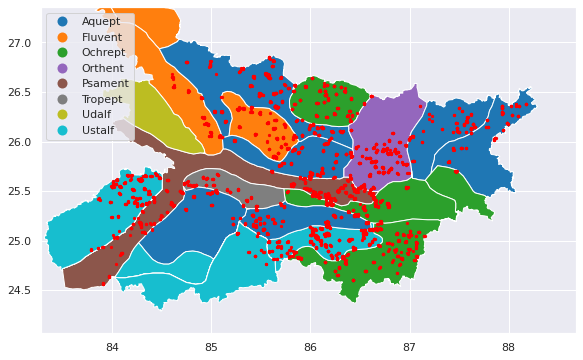

In [16]:
soil_types_gdf = gpd.read_file("../bihar_soil_types/bihar_soil_types.shp")
soil_types_gdf = soil_types_gdf.iloc[1:] # first row is the entire region


ax = soil_types_gdf.plot(soil_types_gdf["soil_type"], figsize=(10, 6), label="soil_type", legend=True)
minx, miny, maxx, maxy = gpd.GeoSeries(sample_points).total_bounds
margin = 0.5
ax.set_xlim(minx - margin, maxx + margin)
ax.set_ylim(miny - margin, maxy + margin)


sample_points_gdf.plot(ax=ax, marker='o', color='red', markersize=5, legend=True)


0

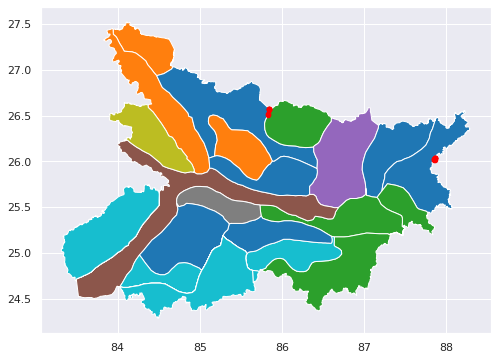

In [17]:

sample_points_gdf = sample_points_gdf.set_crs('epsg:4326') # set coordinate system for the join

dfsjoin = gpd.sjoin(sample_points_gdf, soil_types_gdf, how="left") # Spatial join Points to polygons

unmatched_index = dfsjoin['index_right'].isna() # points that didn't match any region


ax = soil_types_gdf.plot(soil_types_gdf["soil_type"], figsize=(10, 6))
sample_points_gdf[unmatched_index].plot(ax=ax, marker='o', color='red', markersize=20)


# scale them to the centroid of all samples
centroid = Polygon(sample_points).centroid
scale_factor = 0.983
scale_to_centroid = lambda p: scale(p, xfact=scale_factor, yfact=scale_factor, origin=centroid)

sample_points_scaled_gdf = sample_points_gdf.copy()
sample_points_scaled_gdf.loc[unmatched_index, "geometry"] = sample_points_gdf.loc[unmatched_index, "geometry"].apply(scale_to_centroid)

dfsjoin_scaled = gpd.sjoin(sample_points_scaled_gdf, soil_types_gdf, how="left")
dfsjoin_scaled['index_right'].isna().sum() # == 0 with scale factor 0.985

In [18]:
dfpivot = pd.pivot_table(dfsjoin_scaled, index="soil_type", aggfunc={"id": "count"})
assert dfpivot.sum().item() == len(sample_points_gdf)

dfpivot


id
soil_type      
Aquept     1020
Fluvent     232
Ochrept     584
Orthent     290
Psament     340
Tropept     107
Ustalf      610

In [19]:
# remove outliers first
##visualize before outliers removal
###box plots
### histograms
### pca to see outliers
## what kind of outlier removal do we need? one can be an improper measurement of a
## particular nutrient, but something completely else is an outlier in the high dimensional space - an odd soil sample.
## do we want to clip or turn to np.nan or drop? how to treat nans afterwards?

# compare unsupervised clustering with soil types
# maybe first dry chem on sis
# EDA on US data
# towards stratification
# correlations

# apply transforms to skewed variables


dropped 683 rows
dropped 196 rows
dropped 247 rows
dropped 195 rows
dropped 192 rows
dropped 193 rows
dropped 192 rows
dropped 195 rows
dropped 197 rows
dropped 192 rows
dropped 193 rows
dropped 195 rows
dropped 192 rows
dropped 683 rows


<AxesSubplot:>

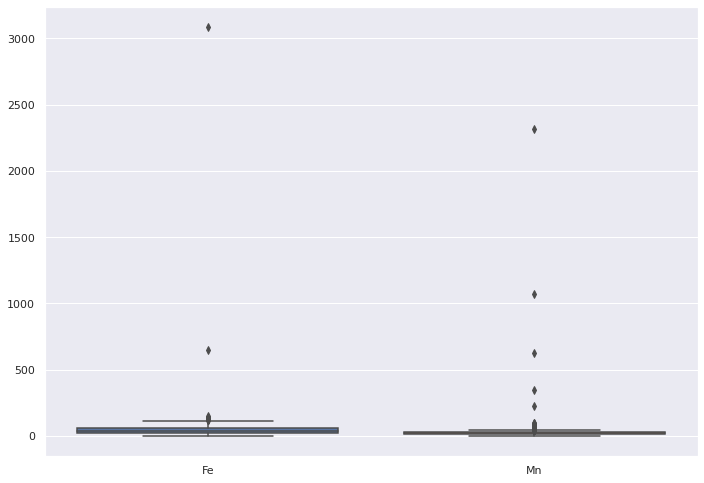

In [22]:

def assert_unreachable(x):
    raise AssertionError(f"Entered a code path that should not be reachable, argument value: {x!r}")

def normalize(df):
    return (df - df.mean()) / df.std()

def unskew(s, threshold=1.5):
    eps = 1e-5
    while skew(s) >= threshold:
        s = s - min(s)
        s = np.log(1 + s)
    return s

def detect_outliers(df_or_s, method="quantile", quantile=0.97, std_mult=3):
    if method == "quantile":
        upper = df_or_s.quantile(quantile)
        lower = df_or_s.quantile(1 - quantile)
        outliers = (df_or_s >= upper) | (df_or_s <= lower)
    elif method == "std":
        outliers = (df_or_s - df_or_s.mean()).abs() >= std_mult * df_or_s.std()
    else:
        assert_unreachable(method)
    return outliers


def drop_outliers(df_or_s, method="quantile",quantile=0.97, std_mult=3):
    df_or_s = df_or_s.copy()
    len_before = len(df_or_s.index)
    outliers = detect_outliers(df_or_s, method, quantile, std_mult)
    if isinstance(df_or_s, DF):
        outliers = outliers.any(axis=1)
    df_or_s = df_or_s[~outliers]
    len_after = len(df_or_s.index)
    print(f"dropped {len_before - len_after} rows")
    return df_or_s
            

        
def drop_outliers_col(df, col, method="quantile", quantile=0.97, std_mult=3):
    outliers = detect_outliers(df[col], method, quantile, std_mult)
    print(f"dropped {outliers.sum()} outliers")
    return df[~outliers]

wcdf_raw = pd.read_csv('/media/Data/sis_dataset/wetchem.csv')


def clean_wcdf(wcdf_raw):
    wcdf_values = wcdf_raw.iloc[:,1:]
    wcdf_unskewed = wcdf_values.apply(unskew)
    wcdf_norm = normalize(wcdf_unskewed)
    wcdf = drop_outliers(wcdf_norm, method="quantile", quantile=0.99)
    return wcdf

wcdf_values = wcdf_raw.iloc[:,1:]
wcdf_unskewed = wcdf_values.apply(unskew)
wcdf_norm = normalize(wcdf_unskewed)
wcdf = drop_outliers(wcdf_norm, method="quantile", quantile=0.99)

def get_clean_wcdf():
    wcdf_raw = pd.read_csv('/media/Data/sis_dataset/wetchem.csv')
    return clean_wcdf(wcdf_raw)

wcdf_cols = [drop_outliers(wcdf_norm[col]) for col in wcdf_norm]
wcdf = clean_wcdf(wcdf_raw)

# sns.set(rc={'figure.figsize':(4.7,8.27)})

sns.boxplot(data=wcdf_raw[["Fe", "Mn"]])
# sns.boxplot(data=wcdf_raw)


In [23]:
# nitrogen quantized

x = pd.Series(wcdf_raw.N.unique()).sort_values().reset_index(drop=True).values
diffs = x[1:] - x[:-1]
diffs = diffs[diffs > 1e-2]
set(diffs)


{12.535999999999518,
 12.537999999999471,
 12.537999999999485,
 12.5379999999995,
 12.539999999999452,
 12.539999999999466,
 12.539999999999537,
 12.53999999999968,
 12.539999999999907,
 12.539999999999992,
 12.541999999999291,
 12.541999999999646,
 12.543999999998732,
 12.54399999999876,
 12.543999999998846,
 12.543999999998903,
 12.543999999998931,
 12.543999999999073,
 12.54399999999913,
 12.543999999999293,
 12.5439999999993,
 12.543999999999414,
 12.543999999999585,
 12.543999999999755,
 12.543999999999812,
 12.543999999999926,
 12.544000000000011,
 12.54400000000011,
 50.176000000000045,
 75.26399999999956,
 75.26400000000058,
 112.8960000000003,
 175.61599999999964}

/home/bart2/test_venv/.venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/bart2/test_venv/.venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/home/bart2/test_venv/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:>

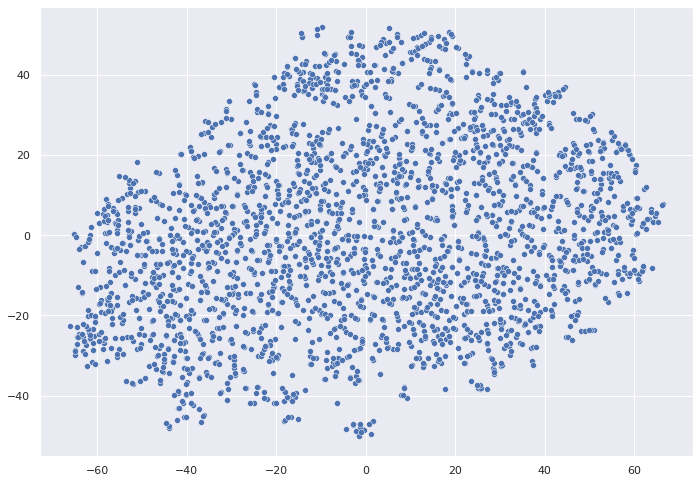

In [24]:
X_tsne = TSNE(n_components=2).fit_transform(wcdf)
sns.scatterplot(X_tsne[:,0], X_tsne[:,1])

<AxesSubplot:>

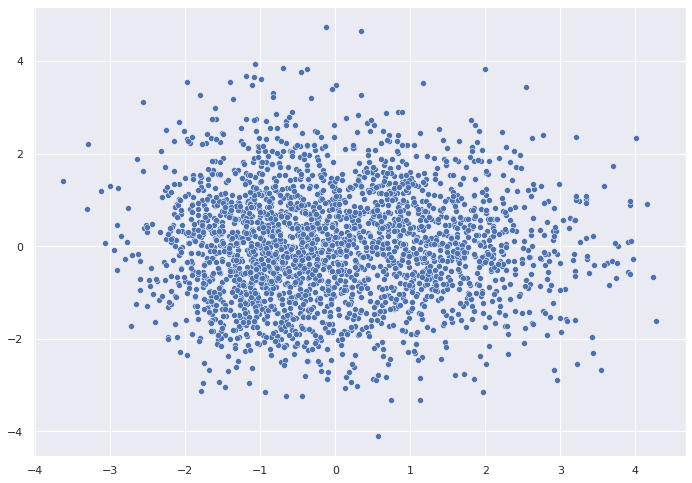

In [25]:
X_pca = PCA(n_components=2).fit_transform(wcdf)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1])

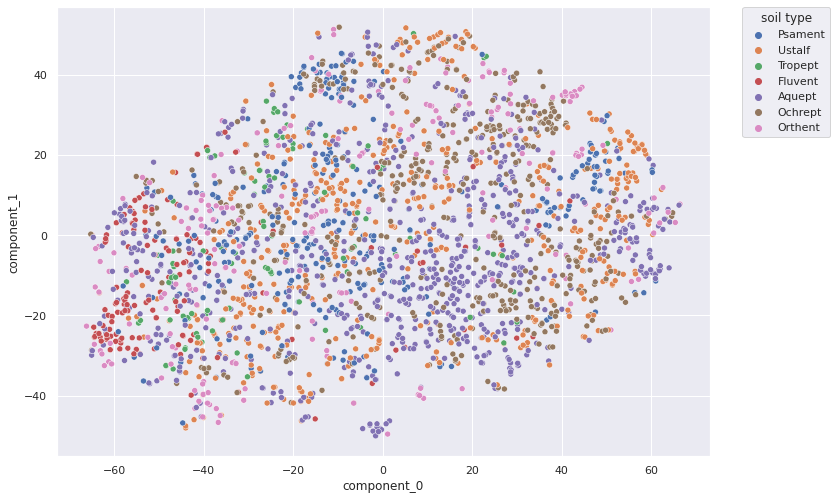

In [26]:
wcdf.join(dfsjoin_scaled)
embedded = DF(X_tsne, columns=["component_0", "component_1"])

embedded.index = wcdf.index
embedded_with_metadata = embedded.join(dfsjoin_scaled)

sns.scatterplot(data=embedded_with_metadata, x="component_0", y="component_1", hue="soil_type")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="soil type")


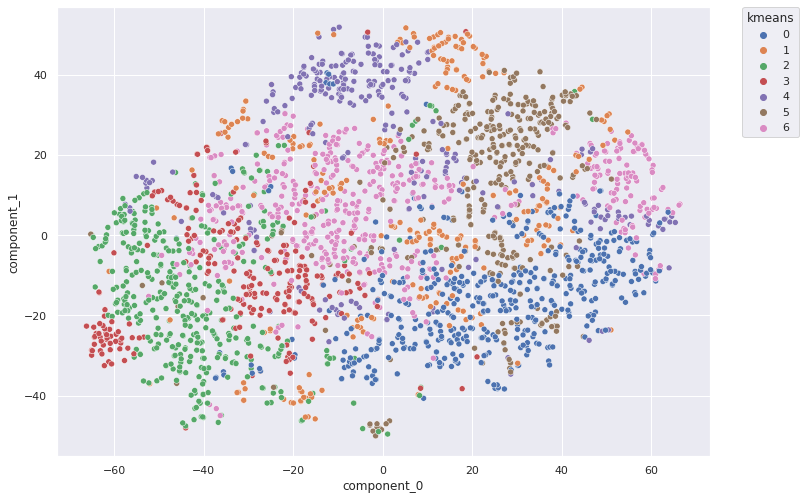

In [27]:
embedded["kmeans"] = KMeans(n_clusters=7).fit(wcdf[wcdf.columns[1:]]).labels_

sns.scatterplot(data=embedded, x="component_0", y="component_1", hue="kmeans", palette="deep")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="kmeans")


dropped 159 outliers
dropped 165 outliers
dropped 154 outliers
dropped 192 outliers
dropped 205 outliers
dropped 154 outliers
dropped 163 outliers
dropped 155 outliers
dropped 152 outliers
dropped 150 outliers
dropped 150 outliers
dropped 151 outliers


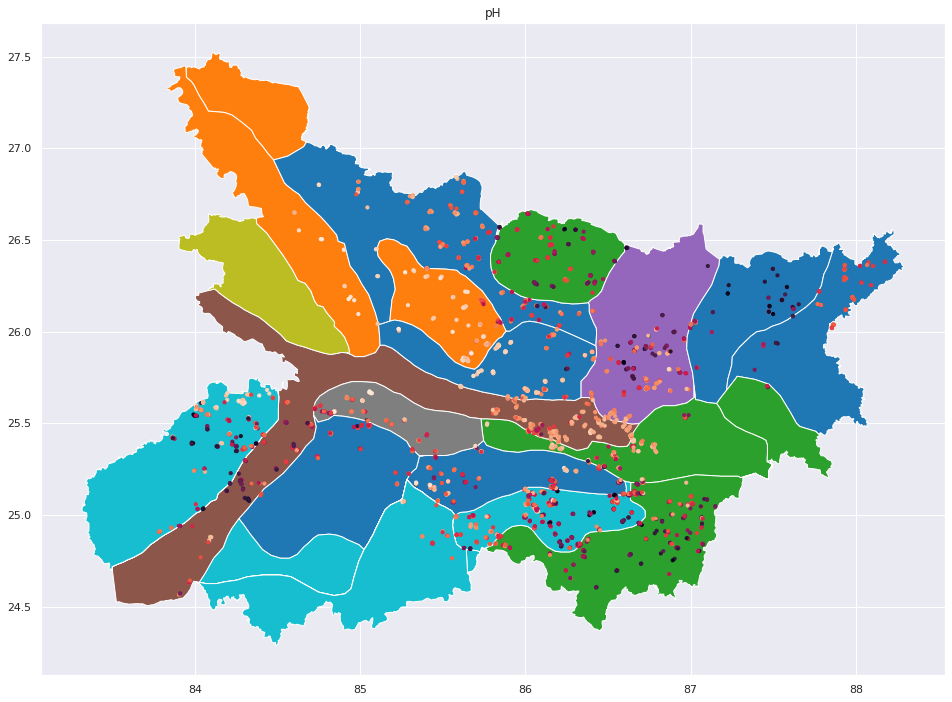

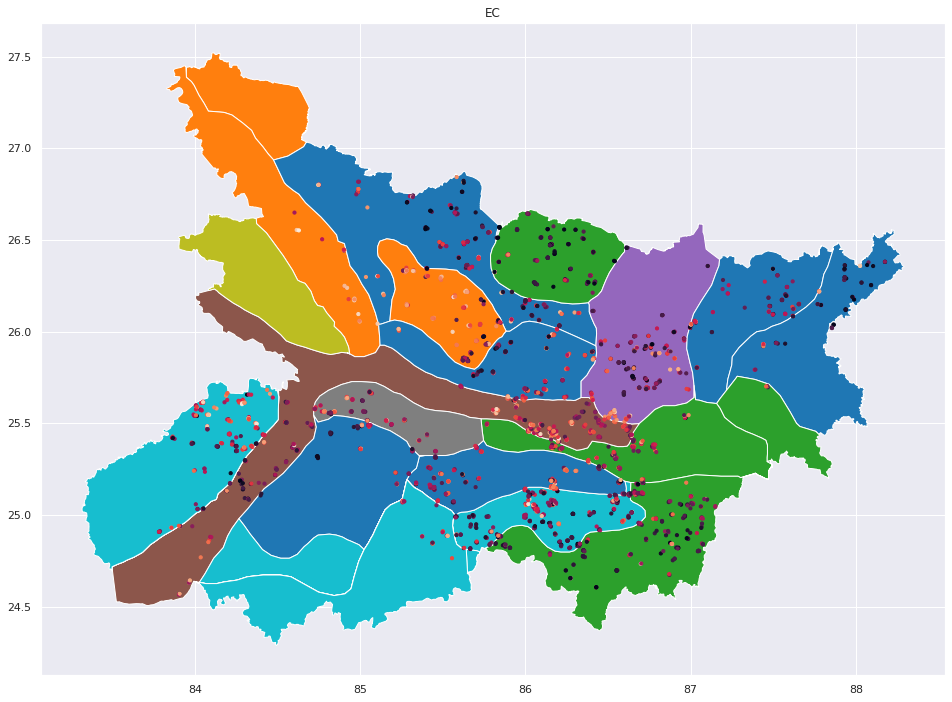

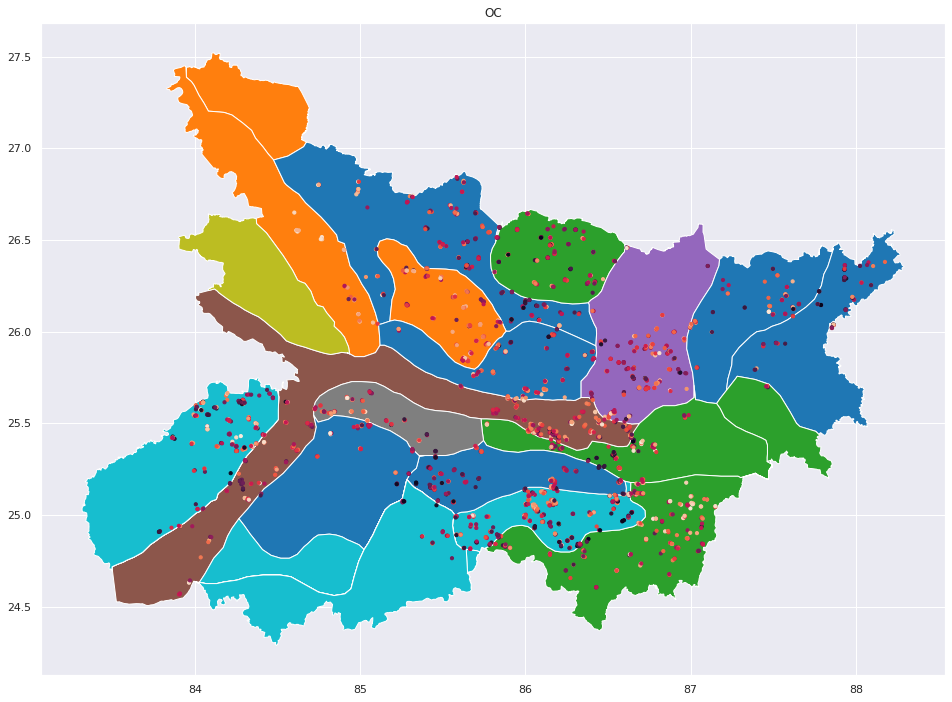

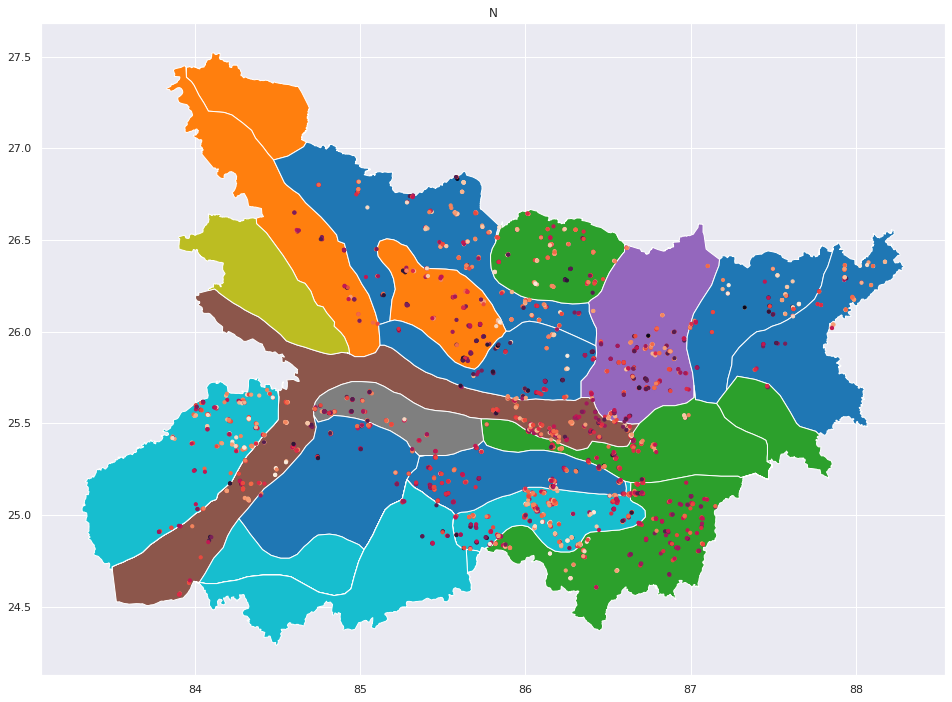

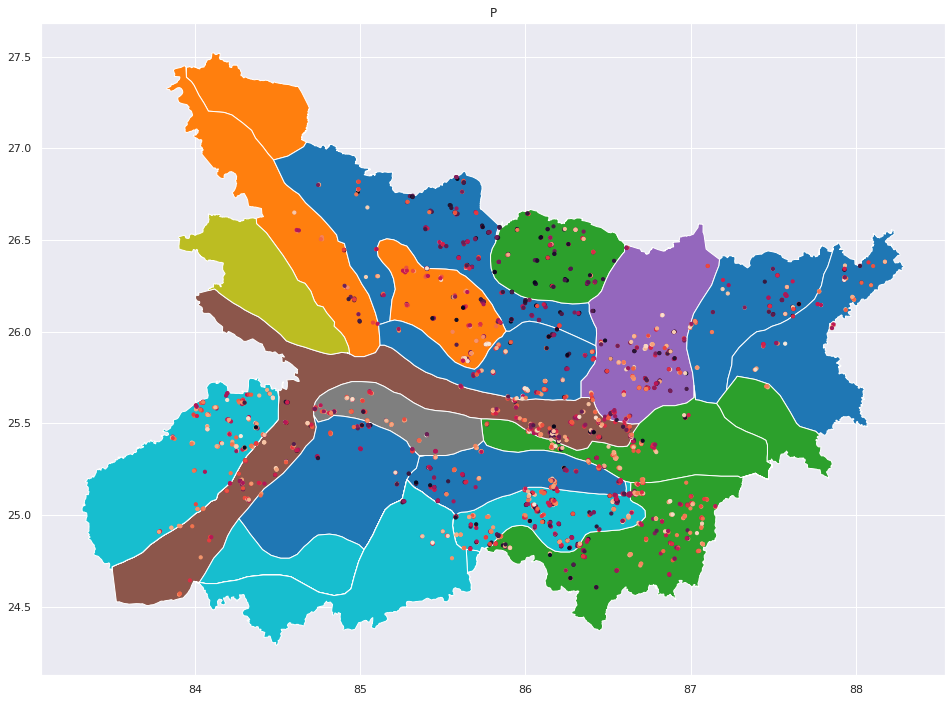

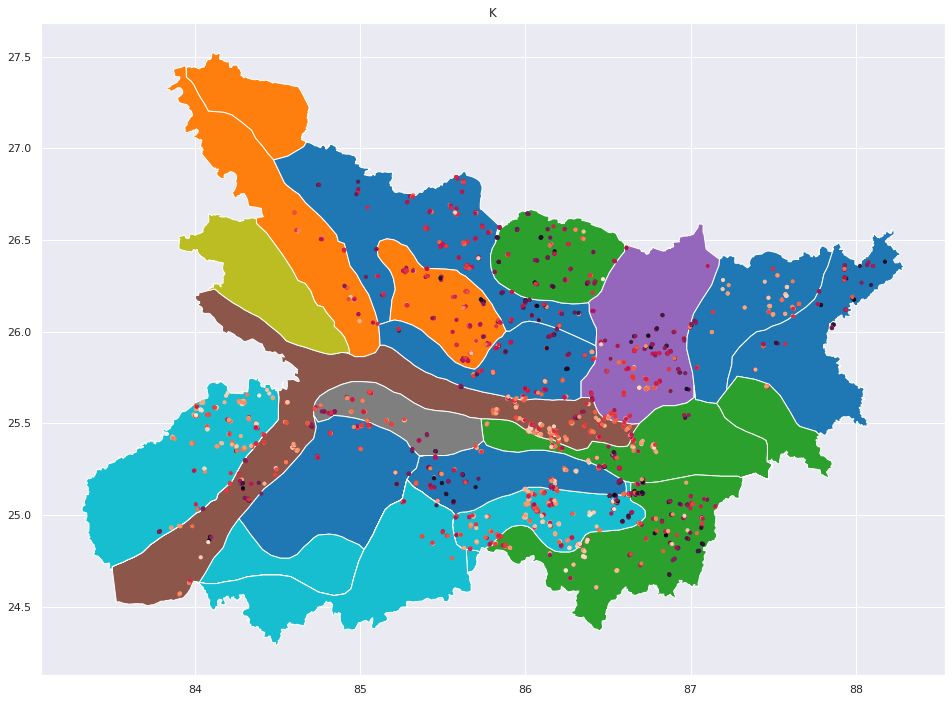

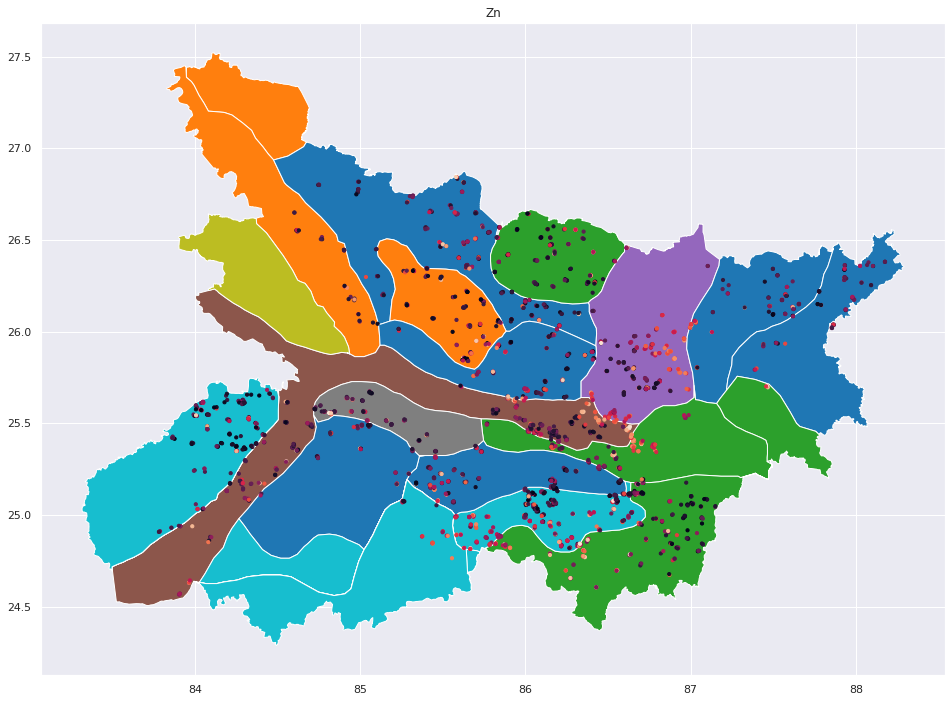

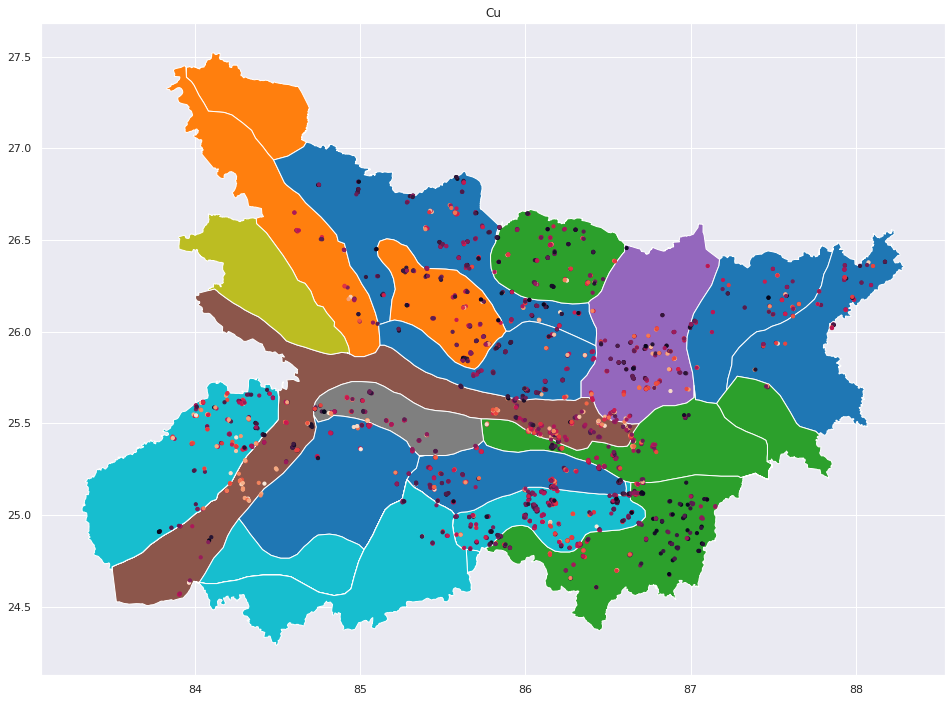

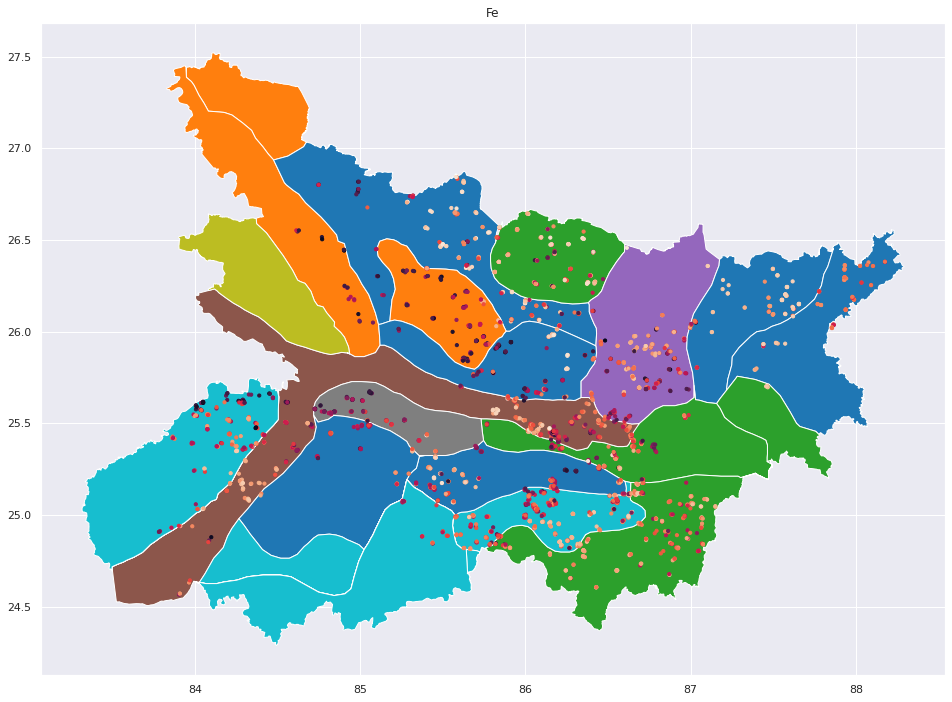

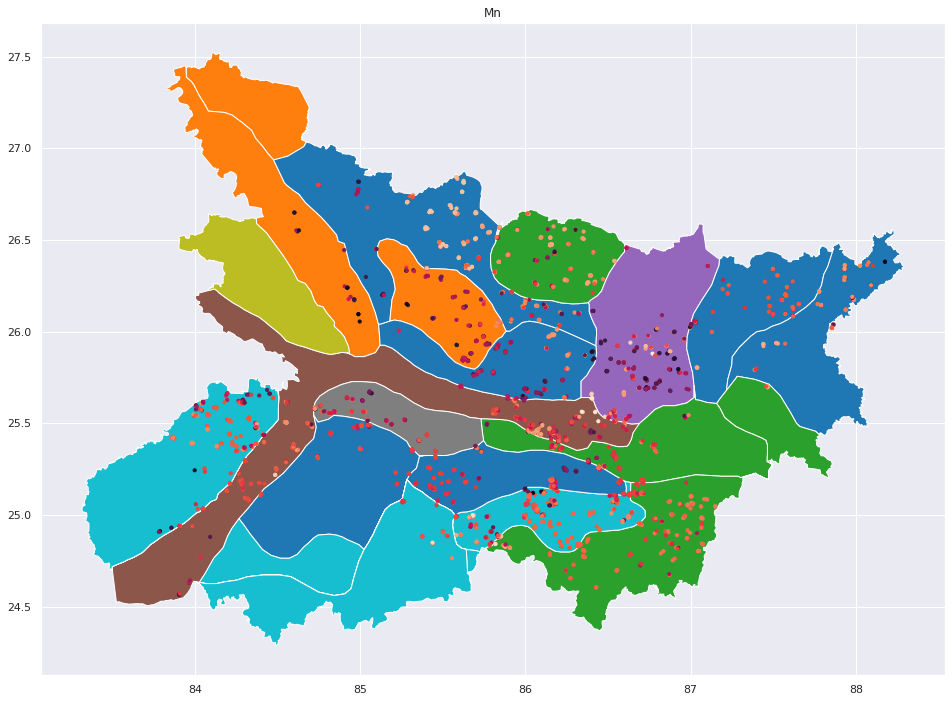

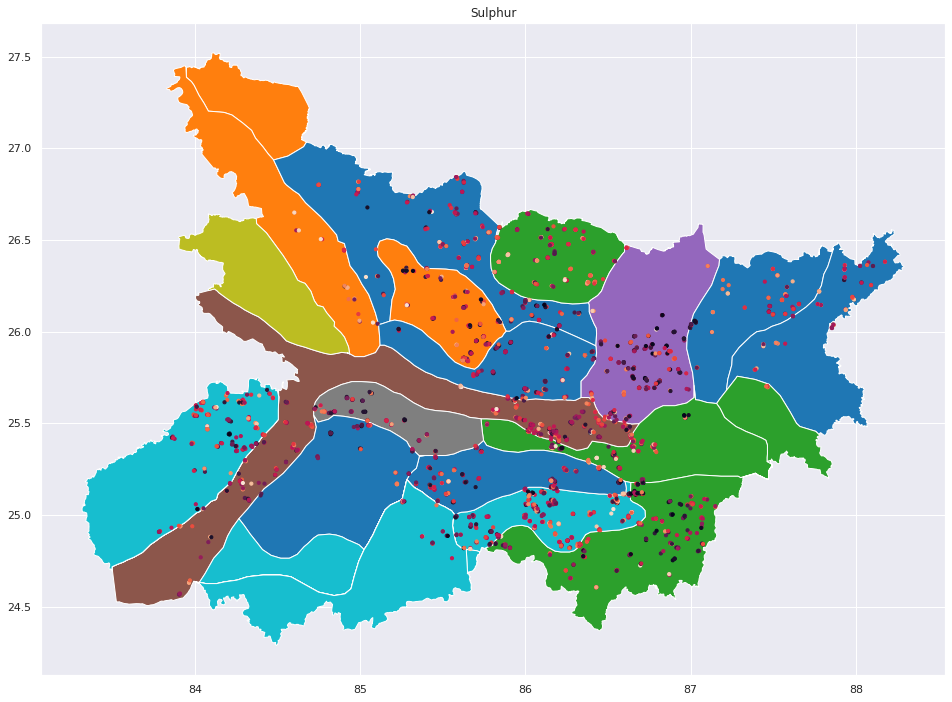

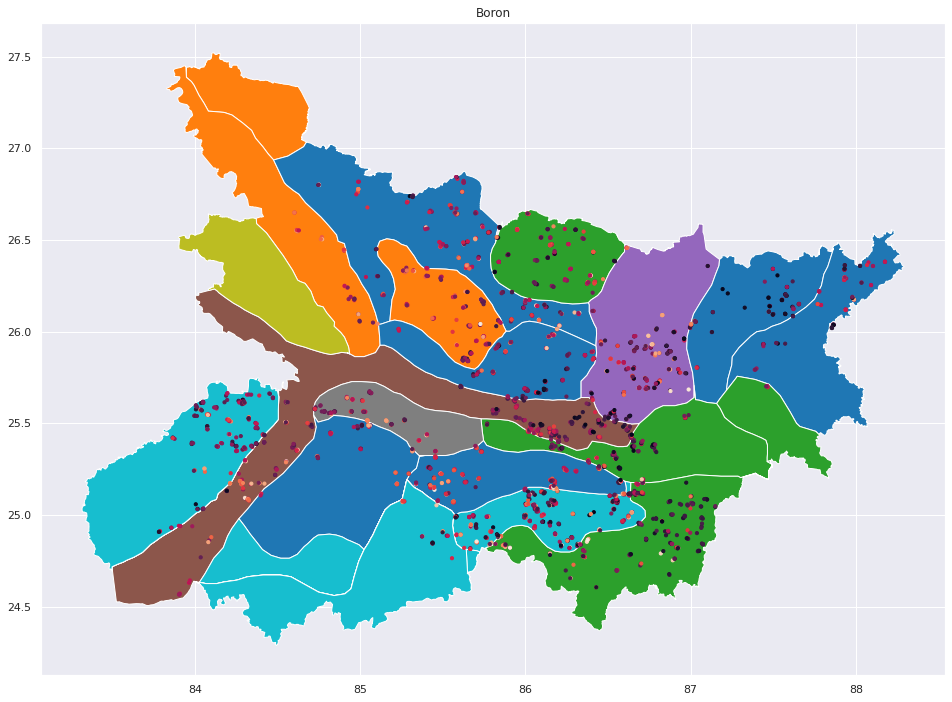

In [30]:
# there is some structure in the above plot - samples labeled as same soil type land close in the embedding space.
# But what if the regions were arbitrarly selected? - color samples on map by 

embedded_with_metadata

wcdf
wc_location = sample_points_gdf.join(wcdf)

for element in wcdf:
    ax = soil_types_gdf.plot(soil_types_gdf["soil_type"], figsize=(20, 12))
    wc_location_no_outliers_for_analyte = drop_outliers_col(wc_location, element)
    wc_location_no_outliers_for_analyte.plot(ax=ax, marker='o', 
                                             c=wc_location_no_outliers_for_analyte[element],
                                             markersize=10)
    ax.set_title(element)


dropped 159 outliers


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

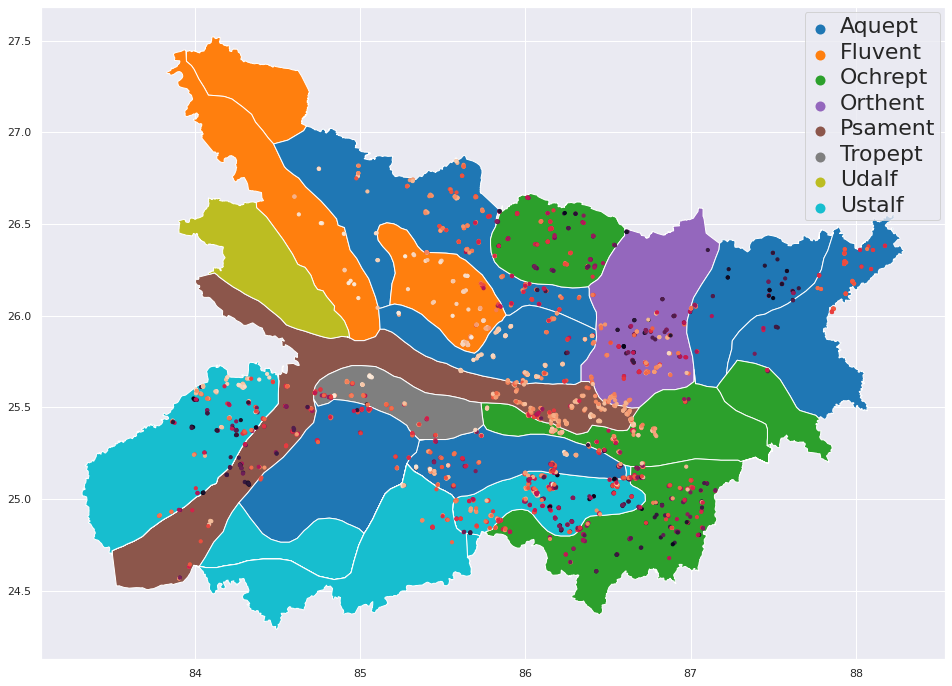

In [38]:
element = "pH"
ax = soil_types_gdf.plot(soil_types_gdf["soil_type"], figsize=(20, 12), legend=True)
wc_location_no_outliers_for_analyte = drop_outliers_col(wc_location, element)
wc_location_no_outliers_for_analyte.plot(ax=ax, marker='o', 
                                         c=wc_location_no_outliers_for_analyte[element],
                                         markersize=10)
plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text


In [29]:
sns.pairplot(wcdf)


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f7a356ea700> (for post_execute):


KeyboardInterrupt: 

some anomalies:
1. Nitrogen values are quantized 
2. Mangan values are cut off at a certain level above which the distribution changes


In [ ]:


# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=bool))

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))

# # Generate a custom diverging colormap

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5}, fmt=".2f")

In [ ]:
corr = wcdf.corr()

plt.figure(figsize=(16,12))
sns.set_theme(style="white")

cmap = sns.diverging_palette(230, 20, as_cmap=True)

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap)

In [ ]:


skew(wcdf)


In [ ]:
boron = drop_outliers(wcdf_raw["Boron"])
skew(np.log(1 + boron))
def unskew1(x, eps=1e-5):
    x = x - min(x)
    return np.log(eps + x)


def unskew2(x):
    x = x - min(x)
    return (1 + x) ** (1/2)


f, axes = plt.subplots(1, 2, figsize=(8,5))
sns.histplot(boron, ax=axes[0])
sns.histplot(drop_outliers(wcdf_raw["Sulphur"]), ax=axes[1])



In [ ]:
# sns.barplot(wcdf_raw.iloc[0])
data = wcdf_norm.iloc[0, 1:] + 1.6
ax = sns.barplot(data.index, data.values)
ax.set_xlabel("analyte")
ax.set_ylabel("amount")